In [32]:
import pandas as pd
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import statistics
from scipy import spatial, stats
import numpy as np
from statistics import mean
import operator
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn. manifold import MDS
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.stats import ttest_ind
import math
import matplotlib.font_manager as font_manager
import os

Read in the meta data an theta matrix in dataframes and reset their indices.

In [33]:
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

In [2]:
path = find('meta.csv', 'C://')
data = pd.read_csv(path)
path = find('thetamatrix50.csv', 'C://')
theta = pd.read_csv(path)
data = data.reset_index(drop=True)

C:\Users\20150624\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (23,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Create a dataframe that reports for every pair of targets and acquirers the median topic proportions over all their documents, if the document was before or after the effective date, the similarity between the target and acquirer vector and their industries.

In [3]:
proportions = pd.DataFrame(columns=['Target', 'Acquiror', 'TargetTopics', 'AcquirorTopics', 'Period', 'Similarity'])
nlp = English()
tokenizer = Tokenizer(nlp.vocab)
target_text_length = list()
acquirer_text_length = list()
before = list()
after = list()
valid_pair_before = list()
valid_pair_after = list()
same_industry = list()
diff_industry = list()
for company in data['companydate'].unique():
    target = list(data[data['companydate']==company]['Target.Name'])[0]
    acquirer = list(data[data['companydate']==company]['Acquiror.Name'])[0]
    target_industry = list(data[data['Target.Name']==target]['Target.Macro.Industry'])[0]
    acquiror_industry = list(data[data['Acquiror.Name']==acquirer]['Acquiror.Macro.Industry'])[0]    
    year = list(data[data['companydate']==company]['DealYear'])[0]
    docyear = list(data[data['companydate']==company]['DocumentYear'])[0]
    pair = (target, acquirer)
    period =list(data[data['companydate']==company]['period'])[0]
    target_topics= list()
    acquiror_topics = list()
    if (period == 'before') and (pair not in before):
        before.append(pair)
        indices = data[(data['Target.Name']==target)&(data['Acquiror.Name']==acquirer)&(data['period']=='before')].index
        target_indices = list()
        acquirer_indices = list()
        target_length = 0
        acquirer_length = 0
        for index in indices:
            if data.iloc[index]['companytype'] == 'Target':
                target_indices.append(index)
            if data.iloc[index]['companytype'] ==  'Acquiror':
                acquirer_indices.append(index)
        for index in target_indices:
            text = data.iloc[index]['clean_text']
            tokens = tokenizer(text)
            target_length += len(tokens)
        for index in acquirer_indices:
            text = data.iloc[index]['clean_text']
            tokens = tokenizer(text)
            acquirer_length += len(tokens)
        target_text_length.append(target_length)
        acquirer_text_length.append(acquirer_length)
        if target_length >=162 and acquirer_length >=162:
            valid_pair_before.append(pair)
            for column in theta.columns:
                if column != 'Unnamed: 0':
                    target_topics.append(theta.iloc[target_indices][column].median())
                    acquiror_topics.append(theta.iloc[acquirer_indices][column].median())
            sum_target_topics=sum(target_topics)
            target_topics = [i/sum_target_topics for i in target_topics]
            sum_acquiror_topics = sum(acquiror_topics)
            acquiror_topics = [i/sum_acquiror_topics for i in acquiror_topics]
            similarity = 1-spatial.distance.euclidean(target_topics, acquiror_topics)
            if target_industry == acquiror_industry:
                same_industry.append(similarity)
            if target_industry != acquiror_industry:
                diff_industry.append(similarity)
            props = pd.DataFrame({'Target':target,'Acquiror':acquirer,'TargetTopics':[target_topics],'AcquirorTopics':[acquiror_topics],'Period':period,
                                 'Target industry':target_industry,'Acquirer industry':acquiror_industry,
                                 'Similarity':similarity,'Year':int(year), 'DocYear':int(docyear)})
            proportions = proportions.append(props)
    if (period == 'after') and (pair not in after):
        after.append(pair)
        indices = data[(data['Target.Name']==target)&(data['Acquiror.Name']==acquirer)&(data['period']=='after')].index
        target_indices = list()
        acquirer_indices = list()
        target_length = 0
        acquirer_length = 0
        for index in indices:
                if data.iloc[index]['companytype'] == 'Target':
                    target_indices.append(index)
                if data.iloc[index]['companytype'] ==  'Acquiror':
                    acquirer_indices.append(index)
        for index in target_indices:
            text = data.iloc[index]['clean_text']
            tokens = tokenizer(text)
            target_length += len(tokens)
        for index in acquirer_indices:
            text = data.iloc[index]['clean_text']
            tokens = tokenizer(text)
            acquirer_length += len(tokens)
        target_text_length.append(target_length)
        acquirer_text_length.append(acquirer_length)
        if target_length >=162 and acquirer_length >=162:
            valid_pair_after.append(pair)
            for column in theta.columns:
                if column != 'Unnamed: 0':
                    target_topics.append(theta.iloc[target_indices][column].median())
                    acquiror_topics.append(theta.iloc[acquirer_indices][column].median())
            sum_target_topics=sum(target_topics)
            target_topics = [i/sum_target_topics for i in target_topics]
            sum_acquiror_topics = sum(acquiror_topics)
            acquiror_topics = [i/sum_acquiror_topics for i in acquiror_topics]                    
            similarity = 1-spatial.distance.euclidean(target_topics, acquiror_topics)
            if target_industry == acquiror_industry:
                same_industry.append(similarity)
            if target_industry != acquiror_industry:
                diff_industry.append(similarity)
            props = pd.DataFrame({'Target':target,'Acquiror':acquirer,'TargetTopics':[target_topics],'AcquirorTopics':[acquiror_topics],'Period':period,
                                 'Target industry':target_industry,'Acquirer industry':acquiror_industry,
                                  'Similarity':similarity, 'Year':int(year),'DocYear':int(docyear)})
            proportions = proportions.append(props)


C:\Users\20150624\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [4]:
proportions

,Acquirer industry,Acquiror,AcquirorTopics,DocYear,Period,Similarity,Target,Target industry,TargetTopics,Year
0,Healthcare,Absolute Total Care,"[0.00904475435754733, 0.003345501720923122, 0....",2010.0,before,0.861673,Carolina Crescent Health Plan,Healthcare,"[0.005597960145786435, 0.0021563806692588613, ...",2010.0
0,Healthcare,Centene Corp,"[0.014813685662987925, 0.004903738188395357, 0...",2013.0,before,0.607572,Specialty Therapeutic Hldg Inc,Retail,"[0.00695398434468514, 0.0002217933282976976, 0...",2013.0
0,Healthcare,DentaQuest LLC,"[0.002163036116416527, 0.00045437753787188386,...",2017.0,before,0.371596,Access Dental Plan LLC,Healthcare,"[0.0022298939174939247, 0.00031808298823092935...",2017.0
0,Healthcare,Tufts Assocd Health Plans Inc,"[0.0106516271344824, 0.011384715648700028, 0.0...",2015.0,before,0.680485,Integra Partners LLC,Financials,"[0.0050995620356424284, 0.005302140636081216, ...",2015.0
0,Healthcare,Aetna Inc,"[0.008960587393831272, 0.006458270350028384, 0...",2011.0,before,0.592219,Healthagen LLC,High Technology,"[0.006498347116312149, 0.001489436368894553, 0...",2011.0
0,Healthcare,WellCare Health Plans Inc,"[0.004456534518803531, 0.0006543031554535112, ...",2013.0,before,0.678634,Aetna Inc-Missouri Medicaid,Healthcare,"[0.005906873304121198, 0.00038608073440771614,...",2013.0
0,Healthcare,Aetna Inc,"[0.0022821447647642787, 0.00035717995789639, 0...",2013.0,before,0.426120,Coventry Health Care Inc,Healthcare,"[0.008774250680172856, 0.002253050586413694, 0...",2013.0
0,Healthcare,Aetna Inc,"[0.002011055297666133, 0.0031400090710780857, ...",2014.0,before,0.603189,bswift LLC,High Technology,"[0.0009751831617086384, 0.00588683912799735, 0...",2014.0
0,Healthcare,UnitedHealth Group Inc,"[0.0006315746781651798, 0.0047417768385622835,...",2017.0,before,0.216138,American Health Network Inc,Healthcare,"[0.036790834455616296, 0.0030046989047821126, ...",2017.0
0,Financials,GIG,"[0.0005204436293681085, 0.00416549580096611, 0...",2017.0,before,0.750701,AIG Sigorta AS,Healthcare,"[0.001831749739083088, 0.01496709131570686, 0....",2017.0


Create a dictionary with the topic numbers as keys and the topic effect sizes for healthcare/financial as values.

In [4]:
topics = dict.fromkeys(np.arange(1,51,1))
tp = [-0.0157,0.0035,0.0253,-0.0013,-0.0074,0.0394,0.0398,-0.0025,-0.0096,-0.0232,-0.0007,0.0103,-0.0027,-0.0258,-0.0016,-0.0100,-0.0118,-0.0098,-0.0119,0.0387,0.0301,0.0122,-0.0095,-0.0040,0.0263,-0.0192,-0.0240,0.0024,-0.0090,-0.0108,0.0219,-0.0227,0.0134,-0.0184,-0.0239,0.0218,-0.0075,-0.0041,-0.0128,-0.0117,-0.0125,0.0427,-0.0228,0.0345,-0.0007,0.0421,-0.0198,-0.0140,-0.0119,-0.0109]
for key in topics.keys():
    topics[key] = tp[key-1]

Compute for each company to which extend it consists of healthcare topics and financial topics by correcting the topic proportions for the effect sizes healthcare/financial.

In [5]:
industrymix = pd.DataFrame(columns=['Target', 'Acquirer', 'TargetTopics', 'AcquirerTopics', 'Period','Industry'])

for index, row in proportions.iterrows():
    tt = row['TargetTopics']
    ttf = 0
    tthc = 0
    for key in topics.keys():
        tp = topics[key]
        if tp>0:
            ttf += tt[key-1]*tp
        elif tp<0:
            tthc += tt[key-1]*tp
    at = row['AcquirorTopics']
    atf = 0
    athc = 0
    for key in topics.keys():
        tp = topics[key]
        if tp>0:
            atf += at[key-1]*tp
        elif tp<0:
            athc += at[key-1]*tp
    tttotal = ((tthc*-1)+ttf)
    attotal = ((athc*-1)+atf)
    tthcf = [tthc*-1/tttotal,ttf/tttotal]
    athcf = [athc*-1/attotal, atf/attotal]
    if row['Target industry'] == row['Acquirer industry']:
        ind = 'Same'
    elif row['Target industry'] != row['Acquirer industry']:
        ind = 'Different'
    industry =  pd.DataFrame({'Target':row['Target'],'Acquirer':row['Acquiror'],'TargetTopics':[tt],'AcquirerTopics':[at],
                              'Period':row['Period'],'TargetIndustry':row['Target industry'],'AcquirerIndustry':row['Acquirer industry'], 'Industry':ind,
                             'AcquirerMix':[athcf],'AcquirerHC':athcf[0],'AcquirerF':athcf[1],
                              'TargetMix':[tthcf],'TargetHC':tthcf[0],'TargetF':tthcf[1]})
    industrymix =industrymix.append(industry, ignore_index=True)


In [31]:
industrymix[industrymix['AcquirerIndustry']=='Financials'].sort_values(by='AcquirerF')

,Acquirer,AcquirerF,AcquirerHC,AcquirerIndustry,AcquirerMix,AcquirerTopics,Industry,Period,Target,TargetF,TargetHC,TargetIndustry,TargetMix,TargetTopics,Distance
132,Ameritas Life Insurance Corp,0.127119,0.872881,Financials,"[0.8728812327912783, 0.12711876720872176]","[0.006463086120839608, 0.0030418173253900327, ...",Different,after,Sec Life Ins Co of America,0.265919,0.734081,Healthcare,"[0.7340810953770184, 0.2659189046229817]","[0.0009000596508139237, 0.0005418105908032119,...",0.196293
23,Blue Cross Blue Shield of MI,0.163095,0.836905,Financials,"[0.8369049920269814, 0.16309500797301857]","[0.0018583383877018554, 0.0026127642855228294,...",Different,before,ikaSystems Corp,0.416433,0.583567,High Technology,"[0.5835671223330554, 0.41643287766694465]","[0.00019647425261204421, 0.002113683551965496,...",0.358274
70,Gravie Inc,0.272208,0.727792,Financials,"[0.7277915216650215, 0.27220847833497863]","[0.00021511198804959611, 0.0016838957182331706...",Same,before,Breitenfeldt Group,0.295803,0.704197,Financials,"[0.7041972373658291, 0.2958027626341708]","[0.0006551815405308669, 0.001112900507382959, ...",0.0333674
202,Railway & Transport Health Fun,0.302832,0.697168,Financials,"[0.6971682890245449, 0.30283171097545514]","[0.003813583341371091, 0.00047618375046796683,...",Different,after,Transport Health Pty Ltd,0.256035,0.743965,Healthcare,"[0.7439646920264408, 0.2560353079735593]","[0.0036048108470191436, 0.0008525765285810811,...",0.0661801
113,Railway & Transport Health Fun,0.312230,0.687770,Financials,"[0.6877695351273422, 0.31223046487265776]","[0.005891102326577248, 0.0011268174507146798, ...",Different,before,Transport Health Pty Ltd,0.345615,0.654385,Healthcare,"[0.6543853406981966, 0.34561465930180346]","[0.009003084623235614, 0.0013480710324030923, ...",0.0472124
161,CCG,0.320658,0.679342,Financials,"[0.6793420412911426, 0.3206579587088575]","[0.015531519594477438, 0.005107144282641709, 0...",Same,after,DTE Risk & Finl Mgmt-Gen Ins,0.873023,0.126977,Financials,"[0.12697734061590293, 0.8730226593840971]","[0.0005820169854495754, 0.004507441887313954, ...",0.781162
10,International Medl Grp Inc,0.329669,0.670331,Financials,"[0.6703308927814979, 0.329669107218502]","[0.11081805750274198, 0.008387566656729784, 0....",Different,before,A La Carte Healthcare Ltd,0.227676,0.772324,Healthcare,"[0.7723243287475521, 0.2276756712524478]","[0.0022967125926870134, 0.0005175067790113886,...",0.144241
69,GMHBA Ltd,0.354020,0.645980,Financials,"[0.6459801135418929, 0.3540198864581071]","[0.006157688874919003, 0.004274758142484755, 0...",Different,before,health.com.au Pty Ltd,0.120452,0.879548,Healthcare,"[0.8795479728339048, 0.12045202716609522]","[0.005127842795025298, 0.0017683148167319902, ...",0.330315
169,GMHBA Ltd,0.521192,0.478808,Financials,"[0.4788080782670993, 0.5211919217329007]","[0.006252048449541329, 0.0015635861254162276, ...",Different,after,health.com.au Pty Ltd,0.078764,0.921236,Healthcare,"[0.9212361760867697, 0.07876382391323032]","[0.008154295036898511, 0.0008799618908511615, ...",0.625688
164,Exor Spa,0.550281,0.449719,Financials,"[0.4497185562626462, 0.5502814437373538]","[0.002155084694105164, 0.0038216134341339716, ...",Same,after,PartnerRe Ltd,0.977072,0.022928,Financials,"[0.02292840379995341, 0.9770715962000467]","[0.0009142792091754578, 0.00884316431673125, 0...",0.603572


Plot the healthcare proportion of acquirers against their financial proportion.

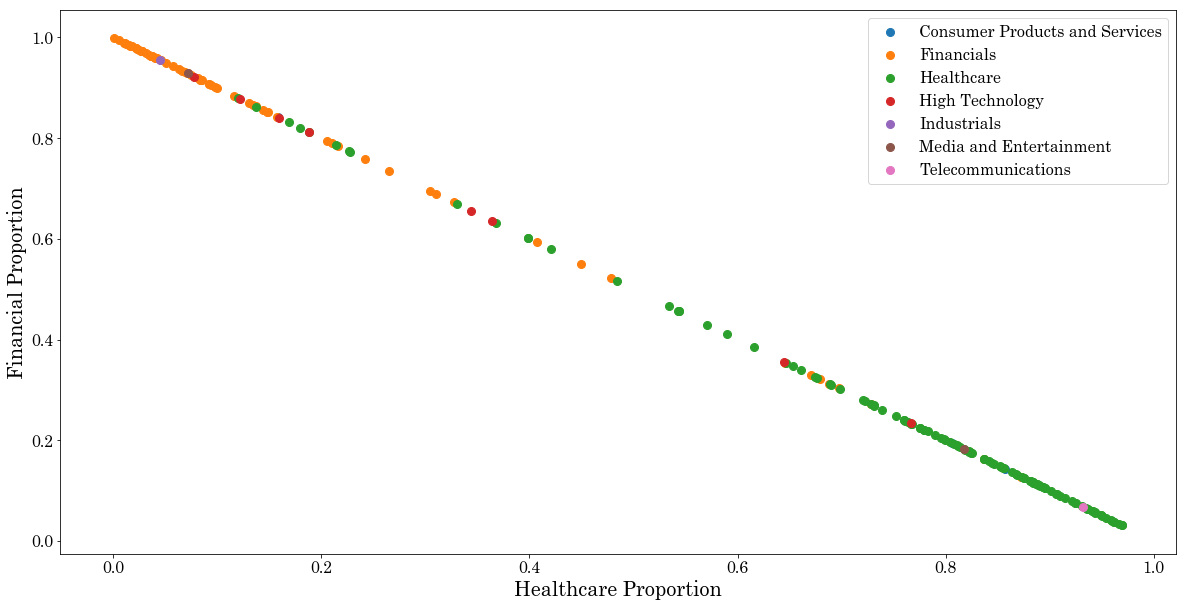

In [8]:
plt.figure(figsize=(20,10))
groups = industrymix.groupby('AcquirerIndustry')
for name, group in groups:
    plt.axis('tight')
    plt.scatter(group['AcquirerHC'], group['AcquirerF'], label=name,s=64)
plt.xticks(fontsize=16, fontname="century")
plt.yticks(fontsize=16, fontname="century")
plt.xlabel('Healthcare Proportion', fontsize=20, fontname="century")
plt.ylabel('Financial Proportion', fontsize=20, fontname="century")
font = font_manager.FontProperties(family='century', size=16)
plt.legend(prop=font)



Plot the healthcare proportion of targets against their financial proportion.

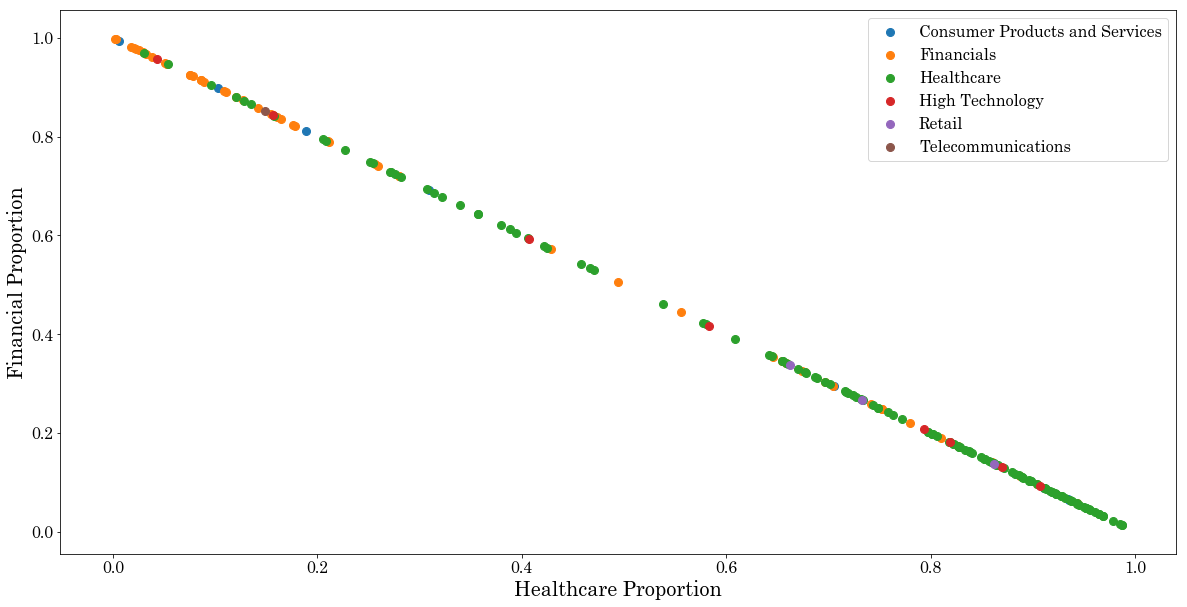

In [9]:
plt.figure(figsize=(20,10))
groups = industrymix.groupby('TargetIndustry')
for name, group in groups:
    plt.axis('tight')
    plt.scatter(group['TargetHC'], group['TargetF'], label=name, s=64)
plt.legend()
plt.legend(prop={'size': 16})
plt.xticks(fontsize=16, fontname="century")
plt.yticks(fontsize=16, fontname="century")
plt.xlabel('Healthcare Proportion', fontsize=20, fontname="century")
plt.ylabel('Financial Proportion', fontsize=20, fontname="century")
font = font_manager.FontProperties(family='century', size=16)
plt.legend(prop=font)


Sort the healthcare and financials companies to compute their means and differences.

In [18]:
hc = list()
fin = list()
for index, row in industrymix.iterrows():
    aind = row['AcquirerIndustry']
    am = row['AcquirerMix']
    tind = row['TargetIndustry']
    tm = row['TargetMix']
    if aind == 'Healthcare':
        hc.append(am)
    if tind == 'Healthcare':
        hc.append(tm)
    if aind =='Financials':
        fin.append(am)
    if tind == 'Financials':
        fin.append(tm)

In [27]:
hchc = [i[0] for i in hc]
hcfin = [i[1] for i in hc]
finhc = [i[0] for i in fin]
finfin = [i[1] for i in fin]
print(mean(hchc))
print(mean(hcfin))
print(mean(finhc))
print(mean(finfin))
print(len(finfin))

0.7315197144785407
0.2684802855214593
0.24081595783140392
0.759184042168596
128


Calculate the distance between the vector of healthcare/financial for a target and acquirer.

In [7]:
industrymix['Distance'] = ""
for index, row in industrymix.iterrows():
    athcf = row['AcquirerMix']
    tthcf = row['TargetMix']
    industrymix.at[index, "Distance"]=spatial.distance.euclidean(athcf, tthcf)


T-test to compute if the distance between companies from the same industry is different from the distance between companies from different industries.

In [8]:
same = industrymix[industrymix['Industry']=='Same']
dif = industrymix[industrymix['Industry']=='Different']
ttest_ind(same['Distance'], dif['Distance'])

Ttest_indResult(statistic=-5.279758770277308, pvalue=3.2728323947153207e-07)

In [9]:
same['Distance'].mean()

0.21161304719274338

In [10]:
dif['Distance'].mean()

0.4341574247772851

For each deal sort the target and acquirer topics in descending order of proportions. Check how often the data-driven topic is the largest topic for a company.

In [14]:
data_driven_target = 0
data_driven_target_names = list()
data_driven_acquirer = 0
data_driven_acquirer_names = list()
for index, row in proportions.iterrows():
    tt = dict.fromkeys(np.arange(1,51,1))
    at = dict.fromkeys(np.arange(1,51,1))
    t = row['TargetTopics']
    a = row['AcquirorTopics']
    for key in tt.keys():
        tt[key] = t[key-1]
    for key in at.keys():
        at[key] = a[key-1]
    tt={k:v for k,v in sorted(tt.items(), key=lambda item: item[1], reverse=True)}
    at={k:v for k,v in sorted(at.items(), key=lambda item: item[1], reverse=True)}
    firstt = list(tt.keys())[0]
    firsta = list(at.keys())[0]
    if firstt == 8:
        data_driven_target +=1
        data_driven_target_names.append(row['Target'])
    if firsta == 8:
        data_driven_acquirer +=1
        data_driven_acquirer_names.append(row['Acquiror'])

Print the companies for which data-driven was the largest topic.

In [15]:
print(set(data_driven_target_names))
print(set(data_driven_acquirer_names))
print(len(set(data_driven_target_names)))
print(len(set(data_driven_acquirer_names)))

{'Extension LLC', 'Your Home Advantage Inc', 'Avalere Health LLC', 'ikaSystems Corp', 'Finomial Corp', 'Certify Data Systems Inc', 'Rise Health Inc', 'Health Integrated Inc', 'Medicity Inc'}
{'Mitchell International Inc', 'Vocera Communications Inc', 'ExlService Holdings Inc', 'Med Tech Solutions', 'Thomson Reuters Corp', 'Primus Capital Fund', 'MediaAlpha LLC', 'Verisk Analytics Inc', 'Inovalon Holdings Inc'}
9
9


Add all the proportions for the data-driven topic over the years.

In [16]:
years_count = dict.fromkeys(np.arange(2010, 2018,1), 0)
years_total = dict.fromkeys(np.arange(2010, 2018,1), 0)
for index, row in proportions.iterrows():
    tt = dict.fromkeys(np.arange(1,51,1))
    at = dict.fromkeys(np.arange(1,51,1))
    t = row['TargetTopics']
    a = row['AcquirorTopics']
    year = int(row['Year'])
    for key in tt.keys():
        tt[key] = t[key-1]
    for key in at.keys():
        at[key] = a[key-1]
    tt={k:v for k,v in sorted(tt.items(), key=lambda item: item[1], reverse=True)}
    at={k:v for k,v in sorted(at.items(), key=lambda item: item[1], reverse=True)}
    years_count[year] += 1
    years_total[year] += tt[8]
    years_total[year] += at[8]

Compute the average proportion for data-driven per year.

In [17]:
years = list()
values = list()
for key in years_count.keys():
    number = years_count[key]
    average = years_total[key]/number
    years.append(key)
    values.append(average)

Plot the average topic proportion of data-driven solutions over the years.

Text(0, 0.5, 'Mean proportion data-driven solutions')

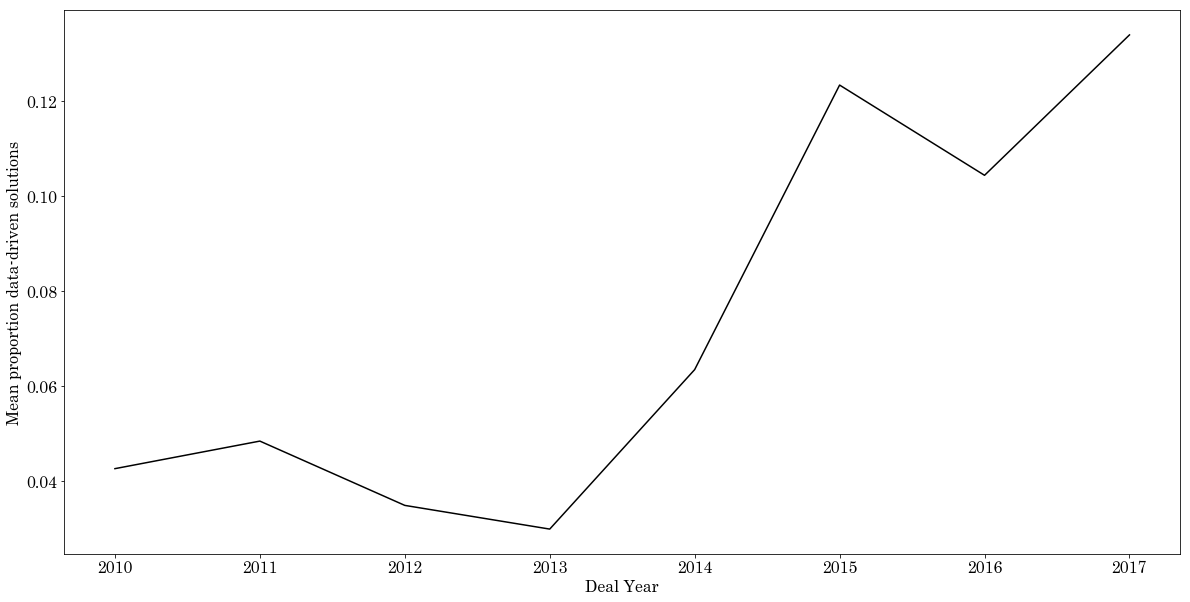

In [20]:
plt.figure(figsize=(20,10))
plt.plot(years, values, color="black")
plt.xticks(fontsize=16, fontname="century")
plt.yticks(fontsize=16, fontname="century")
plt.xlabel('Deal Year', fontname="century", fontsize=16)
plt.ylabel('Mean proportion data-driven solutions', fontname="century", fontsize=16)

Compute proportions for any company, not just those that satisfy the median count of 162 tokens.

In [53]:
proportions = pd.DataFrame(columns=['Target', 'Acquiror', 'TargetTopics', 'AcquirorTopics', 'Period', 'Similarity'])
nlp = English()
tokenizer = Tokenizer(nlp.vocab)
target_text_length = list()
acquirer_text_length = list()
before = list()
after = list()
valid_pair_before = list()
valid_pair_after = list()
same_industry = list()
diff_industry = list()
for company in data['companydate'].unique():
    target = list(data[data['companydate']==company]['Target.Name'])[0]
    acquirer = list(data[data['companydate']==company]['Acquiror.Name'])[0]
    target_industry = list(data[data['Target.Name']==target]['Target.Macro.Industry'])[0]
    acquiror_industry = list(data[data['Acquiror.Name']==acquirer]['Acquiror.Macro.Industry'])[0]    
    year = list(data[data['companydate']==company]['DealYear'])[0]
    docyear = list(data[data['companydate']==company]['DocumentYear'])[0]
    pair = (target, acquirer)
    period =list(data[data['companydate']==company]['period'])[0]
    target_topics= list()
    acquiror_topics = list()
    if (period == 'before') and (pair not in before):
        before.append(pair)
        indices = data[(data['Target.Name']==target)&(data['Acquiror.Name']==acquirer)&(data['period']=='before')].index
        target_indices = list()
        acquirer_indices = list()
        target_length = 0
        acquirer_length = 0
        for index in indices:
            if data.iloc[index]['companytype'] == 'Target':
                target_indices.append(index)
            if data.iloc[index]['companytype'] ==  'Acquiror':
                acquirer_indices.append(index)
        for index in target_indices:
            text = data.iloc[index]['clean_text']
            tokens = tokenizer(text)
            target_length += len(tokens)
        for index in acquirer_indices:
            text = data.iloc[index]['clean_text']
            tokens = tokenizer(text)
            acquirer_length += len(tokens)
        target_text_length.append(target_length)
        acquirer_text_length.append(acquirer_length)
        if target_length >0:
            for column in theta.columns:
                if column != 'Unnamed: 0':
                    target_topics.append(theta.iloc[target_indices][column].median())
            sum_target_topics=sum(target_topics)
            target_topics = [i/sum_target_topics for i in target_topics]
                   
            props = pd.DataFrame({'Target':target,'Acquiror':acquirer,'TargetTopics':[target_topics],'Period':period,
                                 'Target industry':target_industry,'Acquirer industry':acquiror_industry,
                                 'Similarity':similarity,'Year':int(year), 'DocYear':int(docyear)})
            proportions = proportions.append(props)
        if acquirer_length >0:
            for column in theta.columns:
                if column != 'Unnamed: 0':
                    acquiror_topics.append(theta.iloc[acquirer_indices][column].median())
            sum_acquiror_topics = sum(acquiror_topics)
            acquiror_topics = [i/sum_acquiror_topics for i in acquiror_topics]                       
            props = pd.DataFrame({'Target':target,'Acquiror':acquirer,'AcquirorTopics':[acquiror_topics],'Period':period,
                                 'Target industry':target_industry,'Acquirer industry':acquiror_industry,
                                 'Similarity':similarity,'Year':int(year), 'DocYear':int(docyear)})
            proportions = proportions.append(props)
    if (period == 'after') and (pair not in after):
        after.append(pair)
        indices = data[(data['Target.Name']==target)&(data['Acquiror.Name']==acquirer)&(data['period']=='after')].index
        target_indices = list()
        acquirer_indices = list()
        target_length = 0
        acquirer_length = 0
        for index in indices:
            if data.iloc[index]['companytype'] == 'Target':
                target_indices.append(index)
            if data.iloc[index]['companytype'] ==  'Acquiror':
                acquirer_indices.append(index)
        for index in target_indices:
            text = data.iloc[index]['clean_text']
            tokens = tokenizer(text)
            target_length += len(tokens)
        for index in acquirer_indices:
            text = data.iloc[index]['clean_text']
            tokens = tokenizer(text)
            acquirer_length += len(tokens)
        target_text_length.append(target_length)
        acquirer_text_length.append(acquirer_length)
        if target_length >0:
            for column in theta.columns:
                if column != 'Unnamed: 0':
                    target_topics.append(theta.iloc[target_indices][column].median())
            sum_target_topics=sum(target_topics)
            target_topics = [i/sum_target_topics for i in target_topics]                    
            props = pd.DataFrame({'Target':target,'Acquiror':acquirer,'TargetTopics':[target_topics],'Period':period,
                                 'Target industry':target_industry,'Acquirer industry':acquiror_industry,
                                  'Similarity':similarity, 'Year':int(year),'DocYear':int(docyear)})
            proportions = proportions.append(props)
        if acquirer_length >0:
            for column in theta.columns:
                if column != 'Unnamed: 0':
                    acquiror_topics.append(theta.iloc[acquirer_indices][column].median())
            sum_acquiror_topics = sum(acquiror_topics)
            acquiror_topics = [i/sum_acquiror_topics for i in acquiror_topics]                       
            props = pd.DataFrame({'Target':target,'Acquiror':acquirer,'AcquirorTopics':[acquiror_topics],'Period':period,
                                 'Target industry':target_industry,'Acquirer industry':acquiror_industry,
                                  'Similarity':similarity, 'Year':int(year),'DocYear':int(docyear)})
            proportions = proportions.append(props)